## CA1

### HDB Property Resale/Rental Price Analysis

### Table of Contents

<a href='#Section1'><b>1. Package Import</b></a>

<a href='#Section2'><b>2. Prepare dataset info</b></a>

<a href='#Section3'><b>3. Get Dataset</b></a>
- <a href='#Section3.1'>3.1. Generate Dataset Helper Function</a>
- <a href='#Section3.2'>3.2. Resale Flat Price Dataset</a>
- <a href='#Section3.3'>3.3. Rental Flat Price Dataset</a>
- <a href='#Section3.4'>3.4. HDB Units Completion Status by Town Estate Dataset</a>

<a href='#Section4'><b>4. Data Statistical/ Summary information</b></a>
- <a href='#Section4.1'>4.1. Data Search Helper Function</a>
- <a href='#Section4.2'>4.2. Get unique town estate names</a>
- <a href='#Section4.3'>4.3. Get unique flat type names</a>
- <a href='#Section4.4'>4.4. Get median flat price by Town and Flat Type</a>
- <a href='#Section4.5'>4.5. Get median rents by Town and Flat Type</a>
- <a href='#Section4.6'>4.6. Get median number of units completed/ under construction by Town</a>
- <a href='#Section4.7'>4.7. Get top 5 most positive/negative correlation between town estate/flat type and number of units completed/ under construction</a>
    - <a href='#Section4.7.1'>4.7.1 For completed units</a>
    - <a href='#Section4.7.2'>4.7.2 For units under construction</a>

<a href='#Section5'><b>5. Visualizations</b></a>
- <a href='#Section5.1'>5.1. Median Resale Flat Prices for Top 5 towns by transaction volume</a>
- <a href='#Section5.2'>5.2. Resale Flat Price distribution comparison by Flat Type</a>
- <a href='#Section5.3'>5.3. Rental Flat Price comparison for 4- and 5-room flats in top town estates by transaction volume</a>
- <a href='#Section5.4'>5.4. Correlation of resale flat price and flat type completion status</a>

<a id='Section1'><h5>1. Package Import</h5></a>

In [1]:
# Import required packages

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy.lib.recfunctions as rfn
import warnings

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'

warnings.filterwarnings('ignore')

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

<a id='Section2'><h5>2. Prepare dataset info</h5></a>

In [3]:
# Define dataset file/ datatype info in {dataset_key: (Filelist, datatypes)} dictionary

ds_info = {
            # For Resale Flat Price Dataset
            "RFP_1": (
                        ["resale-flat-prices-based-on-approval-date-1990-1999.csv", "resale-flat-prices-based-on-approval-date-2000-feb-2012.csv",
                        "resale-flat-prices-based-on-registration-date-from-mar-2012-to-dec-2014.csv"],
                
                        np.dtype([('month','|U15'), ('town','|U15'), ('flat_type','|U15'), ('block','|U10'), ('street_name','|U30'), 
                                  ('storey_range','|U15'), ('floor_area_sqm','f4'), ('flat_model','|U15'), 
                                  ('lease_commence_date','|U15'), ('resale_price','<i8')])
                     ),
    
            "RFP_2": (
                        ["resale-flat-prices-based-on-registration-date-from-jan-2015-onwards.csv"],
                
                        np.dtype([('month','|U15'), ('town','|U15'), ('flat_type','|U15'), ('block','|U10'), ('street_name','|U30'), 
                                  ('storey_range','|U15'), ('floor_area_sqm','f4'), ('flat_model','|U15'), ('lease_commence_date','|U15'), 
                                  ('remaining_lease','<i4'), ('resale_price','<i8')])
                     ),

            # For Rental Flat Price Dataset
            "MRTF":  (
                        ["median-rent-by-town-and-flat-type.csv"],
                
                        np.dtype([('quarter','|U15'), ('town','|U15'), ('flat_type','|U15'), ('median_rent','<i4')])
                     ),  
    
            # For HDB Units Completion Status by Town Estate Dataset
            "UCS":   (
                        ["completion-status-of-hdb-residential-units-by-town-estate.csv"],

                        np.dtype([('financial_year','|U4'), ('town_or_estate','|U15'), ('hdb_or_dbss','|U15'), 
                                  ('status','|U10'), ('no_of_units','<i4')]) 
                     ) 
}

<a id='Section3'><h5>3. Get Dataset</h5></a>
<a id='Section3.1'><h5>3.1 Generate Dataset Helper Functions</h5></a>

In [4]:
def getData(ds_key):
    """Function for reading data from dataset files using "ds_info" dictionary definition.

    Args:
        ds_key (string): The required key in "ds_info" dictionary

    Returns:
        numpy array    : Dataset read from csv file
    """
    
    (filelist, dtypes) = ds_info[ds_key]
    data = []
    data_merged = []
    for fname in filelist:
        data = np.genfromtxt("Dataset/" + ds_key + "/" + fname, 
                                 skip_header=1, 
                                 dtype=dtypes, 
                                 delimiter=",",
                                 missing_values=['na','-'], 
                                 filling_values=0)     

        # remove index column from dataset
        data_merged = rfn.stack_arrays((data_merged,data))
        filtered = [x for x in data_merged.dtype.names if x not in ["f0"]]

    return data_merged[filtered]

In [5]:
def printDataSummary(ds, ds_key):
    """Function for displaying dataset basic information e.g. number of records, field definition, sample data record.

    Args:
        ds (numpy array): Dataset read from csv file
        ds_key (string) : The required key in "ds_info" dictionary

    Returns:
        None.
    """
    
    print("Total Number of Records in {}: {}".format(ds_key, len(ds)))
    print()
    print("Data fields from {}:".format(ds_key))
    print(ds.dtype.names)
    print()
    print("Sample Data from {}:".format(ds_key))
    print(ds[0:1])
    print()

<a id='Section3.2'><h5>3.2 Resale Flat Price Dataset</h5></a>

In [6]:
# Read Resale Flat Price info from csv file (defined in "RFP_1" key) 
ds_RFP_1 = getData("RFP_1")

# Get Resale Flat Price info from csv file (defined in "RFP_2" key)     
ds_RFP_2 = getData("RFP_2")

# Filter RFP_2 dataset to exclude "remaining_lease" column
filtered = [x for x in ds_RFP_2.dtype.names if x not in ["remaining_lease"]]
ds_RFP_2_filtered = ds_RFP_2[filtered]

# Merge RFP_1 and RFP_2 datasets into single ds_RFP dataset
ds_RFP = rfn.stack_arrays((ds_RFP_1,ds_RFP_2_filtered))
printDataSummary(ds_RFP, "RFP")

Total Number of Records in RFP: 793596

Data fields from RFP:
('month', 'town', 'flat_type', 'block', 'street_name', 'storey_range', 'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price')

Sample Data from RFP:
[('1990-01', 'ANG MO KIO', '1 ROOM', '309', 'ANG MO KIO AVE 1', '10 TO 12', 31.0, 'IMPROVED', '1977', 9000)]



In [7]:
# Define search and replace texts for "flat_model" field
str_Search = ['2-room', 'Adjoined flat', 'Apartment', 'Improved', 'Improved-Maison', 'Maisonette', 'Model A-Maisone', 'Model A', 
              'Multi Generatio', 'Model A2', 'New Generation', 'Premium Apartme', 'Premium Maisone', 'Simplified', 'Standard', 
              'Terrace', 'Type S1', 'Type S2']
str_Replace = ['2-ROOM', 'ADJOINED FLAT', 'APARTMENT', 'IMPROVED', 'IMPROVED-MAISON', 'MAISONETTE', 'MODEL A-MAISONE', 'MODEL A', 
               'MULTI GENERATIO', 'MODEL A2', 'NEW GENERATION', 'PREMIUM APARTME', 'PREMIUM MAISONE', 'SIMPLIFIED', 'STANDARD', 
               'TERRACE', 'TYPE S1', 'TYPE S2']

# Perform text search/replace for "flat_model" field
for i in range(len(str_Search)):
    ds_RFP['flat_model'][ds_RFP['flat_model'] == str_Search[i]] = str_Replace[i]

In [8]:
# Define search and replace texts for "flat_type" field
str_Search = ['MULTI GENERATIO', 'MULTI-GENERATIO']
str_Replace = ['MULTI-GENERATIO', 'MULTI-GENERATIO']

# Perform text search/replace for "flat_type" field
for i in range(len(str_Search)):
    ds_RFP['flat_type'][ds_RFP['flat_type'] == str_Search[i]] = str_Replace[i]

<a id='Section3.3'><h5>3.3 Rental Flat Price Dataset</h5></a>

In [9]:
# Get HDB Median Rent info from csv file    
ds_MRTF_key = "MRTF"
ds_MRTF = getData(ds_MRTF_key)
printDataSummary(ds_MRTF, ds_MRTF_key)

Total Number of Records in MRTF: 8781

Data fields from MRTF:
('quarter', 'town', 'flat_type', 'median_rent')

Sample Data from MRTF:
[('2005-Q2', 'ANG MO KIO', '1-RM', 0)]



<a id='Section3.4'><h5>3.4 HDB Units Completion Status by Town Estate Dataset</h5></a>

In [10]:
# Get Completion Status of HDB Residential Units by Town Estate info from csv file 
ds_UCS_key = "UCS"
ds_UCS = getData(ds_UCS_key)
printDataSummary(ds_UCS, ds_UCS_key)

Total Number of Records in UCS: 884

Data fields from UCS:
('financial_year', 'town_or_estate', 'hdb_or_dbss', 'status', 'no_of_units')

Sample Data from UCS:
[('2008', 'Ang Mo Kio', 'HDB', 'Under Cons', 1221)]



<a id='Section4'><h5>4. Data Statistical/ Summary information</h5></a>
<a id='Section4.1'><h5>4.1 Data Search Helper Function</h5></a>

In [11]:
def searchDS(ds, col, searchString):
    """Function for filtering dataset by column searchstring.

    Args:
        ds (numpy array)      : Dataset read from csv file
        col (string)          : Column name to search
        searchString (string) : Filter criteria for col

    Returns:
        numpy array           : Filtered Dataset meeting search criteria
    """
    
    column_to_search = ds[:][col]
    out = [i for i, v in enumerate(column_to_search) if searchString in v]
    return ds[out]

In [12]:
def getNumStatsPerMultiCatPeriod(ds, cat_col, subcat_col, num_col, year_col, fromYear, toYear):
    """Function for 2-tier data summarization.

    Args:
        ds (numpy array)      : Dataset read from csv file
        cat_col (string)      : First tier column name e.g. town
        subcat_col (string)   : Second tier column name e.g. flat type/model
        num_col (string)      : Column from which data is to be summarized
        year_col (string)     : Column for year information
        fromYear (integer)    : Start year for data summarization
        toYear (integer)      : End year for data summarization
        
    Returns:
        Dictionary            : Summarized data in dictionary format (key information as below) - 
                                median (list)      - Median yearly values e.g. [8000, 9000...]
                                vals (list)        - Original values e.g. [8500, 9500...]
                                TimePeriod (tuple) - Start and end year e.g. (2008, 2019)
                                Cat_Unique (list)  - First tier column unique values
    """
    
    trans_Period_list = {}

    cat_list = ds[:][cat_col]
    cat_list_uniq = np.unique(cat_list)
    
    subcat_list = ds[:][subcat_col]
    subcat_list_uniq = np.unique(subcat_list)
    
    for cat in cat_list_uniq:      
        data_cat = searchDS(ds, cat_col, cat)

        cat_fmt = cat.upper()
        trans_Period_list[cat_fmt] = {}
        
        for subcat in subcat_list_uniq:      
            data_subcat = searchDS(data_cat, subcat_col, subcat)

            subcat_fmt = subcat.upper()
            trans_Period_list[cat_fmt][subcat_fmt] = {}
                
            year_median = []    
            year_vals = [] 
                    
            for year in range(fromYear, toYear + 1):
                data_year = searchDS(data_subcat, year_col, str(year))

                if(len(data_year) != 0):
                    # Calculate median flat price info per year
                    val = np.median(data_year[:][num_col])
                    year_median.append(val)
                            
                    # Store resale flat prices per year    
                    val = list(data_year[:][num_col])
                    year_vals.append(val)
                else:
                    year_median.append(0)
                    year_vals.append([])

                trans_Period_list[cat_fmt][subcat_fmt]["median"] = year_median
                trans_Period_list[cat_fmt][subcat_fmt]["vals"] = year_vals

    trans_Period_list["TimePeriod"] = (fromYear, toYear)
    trans_Period_list["Cat_Unique"] = cat_list_uniq 

    return trans_Period_list

In [13]:
def show_corr(corrlist, title):
    """Function to display correlation information

    Args:
        corrlist (numpy array) : Tuple of top 5 positive/negative correlation list
        title (string)         : Title
        
    Returns:
        None
    """
    
    print(title)
    for corr in corrlist:
        (town_flattype, corrcoef) = corr   
        print("{:30} {}".format(town_flattype, corrcoef))
    print()   

In [14]:
def getCorr(rs_RFP, rs_UCS, status): 
    """Function to get correlation info based on Resale Flat Price and HDB Units Completion Status by Town Estate datasets.

    Args:
        rs_RFP (numpy array) : Dictionary of yearly median resale flat price per town estate
        rs_UCS (numpy array) : Dictionary of yearly median number of units completed/ under construction per town estate
        status (string)      : Unit completion status (COMPLETED/ UNDER CONS)
        
    Returns:
        Tuple                : Top 5 positive correlated town Estate Flat Type/ number of units 
                               Top 5 negative correlated town Estate Flat Type/ number of units 
    """
    
    corrlist = {}

    for i, town in enumerate(towns_uniq):
        town_name = town.upper()
        
        try:
            for flat_type in flattypes_uniq:
                y = rs_RFP[town_name][flat_type]["median"]
                x = rs_UCS[town_name][status]["median"]
                corr_name = town_name + " - " + flat_type
                corrlist[corr_name] = np.round(np.corrcoef(x,y)[0][1], decimals=2)
        except Exception as e:
            pass
    
    corrlist_valid = {k: corrlist[k] for k in corrlist if str(corrlist[k]) != 'nan'}
    corrlist_sorted = sorted(corrlist_valid.items(), key=lambda kv: kv[1], reverse=True)

    top_pos_corrlist = corrlist_sorted[0:5]

    top_neg_corrlist = sorted(corrlist_sorted[-5:],key=lambda x:(x[1],x[0]))
    
    show_corr(top_pos_corrlist, "Town Estate/ Flat Type most positively correlated with units - " + status)
    show_corr(top_neg_corrlist, "Town Estate/ Flat Type most negatively correlated with units - " + status)
    
    return (top_pos_corrlist, top_neg_corrlist)

<a id='Section4.2'><h5>4.2. Get unique town estate names</h5></a>

In [15]:
towns = ds_RFP[:]['town']
towns_uniq = np.unique(towns)

<a id='Section4.3'><h5>4.3. Get unique flat type names</h5></a>

In [16]:
flattypes = ds_RFP[:]['flat_type']
flattypes_uniq = np.unique(flattypes)

In [17]:
streetnames = ds_RFP[:]['street_name']
streetnames_uniq = np.unique(streetnames)

<a id='Section4.4'><h5>4.4. Get median flat price by Town and Flat Type</h5></a>

In [18]:
# Get yearly median resale flat price per town estate
RP_Town_flattype_Period = getNumStatsPerMultiCatPeriod(ds_RFP, "town", "flat_type", "resale_price", "month", 2008, 2019)

# Get yearly median resale flat price per flat type
RP_Town_flatmodel_Period = getNumStatsPerMultiCatPeriod(ds_RFP, "town", "flat_model", "resale_price", "month", 2008, 2019)

<a id='Section4.5'><h5>4.5. Get median rents by Town and Flat Type</h5></a>

In [19]:
# Get yearly median rental flat price per flat type
MR_Town_flattype_Period = getNumStatsPerMultiCatPeriod(ds_MRTF, "town", "flat_type", "median_rent", "quarter", 2005, 2019)

<a id='Section4.6'><h5>4.6. Get median number of units completed/ under construction by Town</h5></a>

In [20]:
# Get yearly median number of units completed/ under construction per town estate
RP_Town_Units_Period = getNumStatsPerMultiCatPeriod(ds_UCS, "town_or_estate", "status", "no_of_units", "financial_year", 2008, 2019)

<a id='Section4.7'><h5>4.7. Get top 5 most positive/negative correlation between town estate/flat type and number of units completed/ under construction</h5></a>

<a id='Section4.7.1'><h5>4.7.1 For completed units</h5></a>

In [21]:
top_poscorr_comp, top_negcorr_comp = getCorr(RP_Town_flattype_Period, RP_Town_Units_Period, "COMPLETED")

Town Estate/ Flat Type most positively correlated with units - COMPLETED
CENTRAL AREA - EXECUTIVE       1.0
YISHUN - 3 ROOM                0.55
YISHUN - 4 ROOM                0.52
HOUGANG - 3 ROOM               0.47
BUKIT PANJANG - 3 ROOM         0.46

Town Estate/ Flat Type most negatively correlated with units - COMPLETED
CENTRAL AREA - 3 ROOM          -0.56
CENTRAL AREA - 2 ROOM          -0.53
SERANGOON - 2 ROOM             -0.53
BUKIT PANJANG - 2 ROOM         -0.39
QUEENSTOWN - 5 ROOM            -0.39



<a id='Section4.7.2'><h5>4.7.2 For units under construction</h5></a>

In [22]:
top_poscorr_uc, top_negcorr_uc = getCorr(RP_Town_flattype_Period, RP_Town_Units_Period, "UNDER CONS")

Town Estate/ Flat Type most positively correlated with units - UNDER CONS
BEDOK - 2 ROOM                 0.81
CHOA CHU KANG - 5 ROOM         0.8
CHOA CHU KANG - 4 ROOM         0.78
BEDOK - 3 ROOM                 0.76
BEDOK - 4 ROOM                 0.74

Town Estate/ Flat Type most negatively correlated with units - UNDER CONS
CLEMENTI - EXECUTIVE           -0.84
JURONG EAST - EXECUTIVE        -0.84
QUEENSTOWN - 4 ROOM            -0.83
JURONG EAST - 5 ROOM           -0.79
CLEMENTI - 4 ROOM              -0.77



<a id='Section5'><h5>5. Visualizations</h5></a>
<a id='Section5.1'><h5>5.1. Median Resale Flat Prices for Top 5 towns by transaction volume</h5></a>

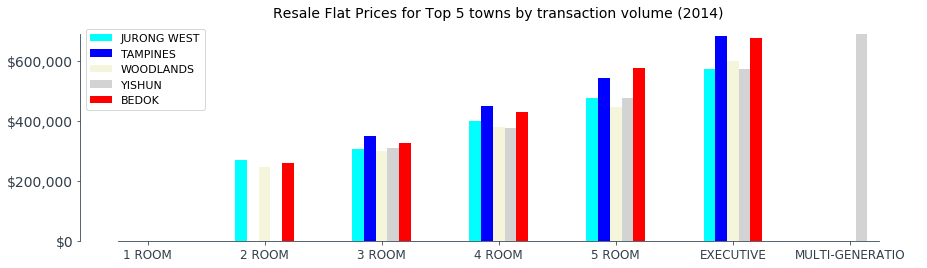

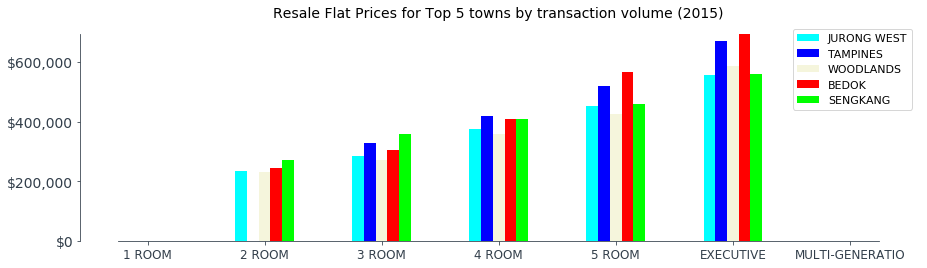

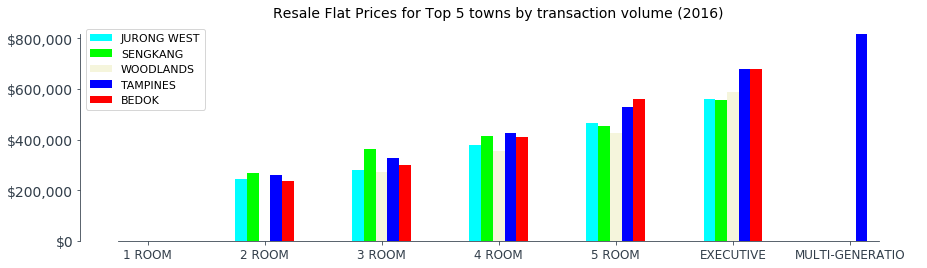

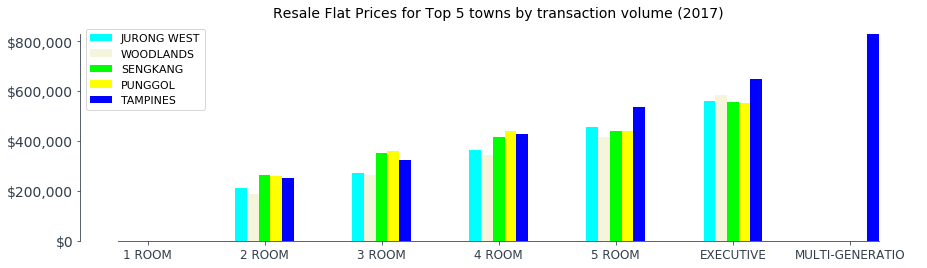

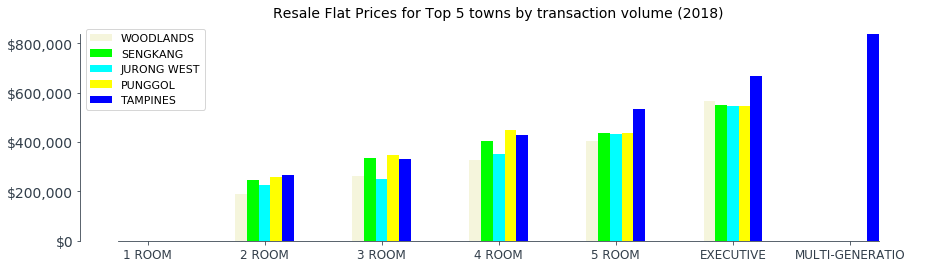

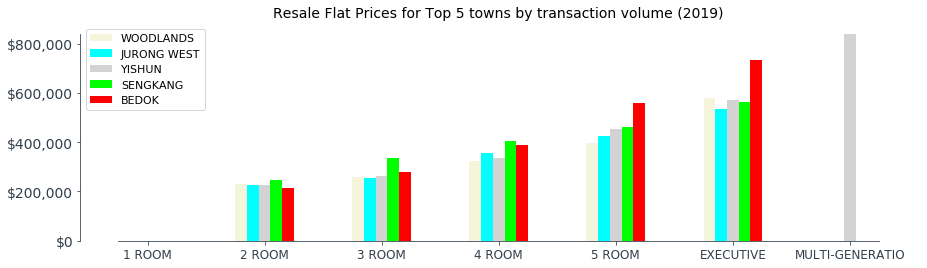

In [23]:
def plotBar(transStats, highestTransTowns, flattype_list_uniq, year):
    """Function for displaying bar chart.

    Args:
        transStats (list)          : List of median resale flat price by flat type for each town estate (top 5)
        highestTransTowns (list)   : Top 5 town estates by transaction volume
        flattype_list_uniq (list)  : List of unique flat types e.g. 1-room, 2.room etc.
        year (integer)             : Year of interest
        
    Returns:
        None
    """
    
    fig, ax = plt.subplots(figsize=(15,4))

    ind = np.arange(len(transStats[0]) )    # the x locations for the groups
    width = 0.1                            # the width of the bars

    town_colors = {'BEDOK': 'red', 'TAMPINES': 'blue', 'SENGKANG': 'lime', 'PUNGGOL': 'yellow', 
                   'WOODLANDS': 'beige', 'JURONG WEST': 'cyan', 'YISHUN': 'lightgray'}
    #town_alpha = {'BEDOK': 1.0, 'TAMPINES': 1.0, 'SENGKANG': 0.6, 'PUNGGOL': 0.6, 
    #               'WOODLANDS': 0.3, 'JURONG WEST': 0.3, 'YISHUN': 0.3}    
    
    p1 = ax.bar(ind, transStats[0], width, bottom=0, color=town_colors[highestTransTowns[0]])
    p2 = ax.bar(ind + width, transStats[1], width, bottom=0, color=town_colors[highestTransTowns[1]])
    p3 = ax.bar(ind + width*2, transStats[2], width, bottom=0, color=town_colors[highestTransTowns[2]])
    p4 = ax.bar(ind + width*3, transStats[3], width, bottom=0, color=town_colors[highestTransTowns[3]])
    p5 = ax.bar(ind + width*4, transStats[4], width, bottom=0, color=town_colors[highestTransTowns[4]])

    ax.set_title("Resale Flat Prices for Top 5 towns by transaction volume ({})".format(year), fontsize=14)
    ax.set_xticks((ind + 2*width))
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
    ax.yaxis.set_tick_params(labelsize=14)
    ax.set_xticklabels(flattype_list_uniq, fontsize=12)
    ax.set_xticklabels(flattype_list_uniq, fontsize=12)
    
    # change the style of the axis spines
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_smart_bounds(True)
    ax.spines['bottom'].set_smart_bounds(True)
    
    ax.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), highestTransTowns, fontsize=11)
    ax.autoscale_view()

    plt.show()

def showResaleFlatPriceDistribuctionByFlatType(ds, k, year):
    """Function for preparing data for bar chart visualization.

    Args:
        ds (numpy array) : Resale Flat Price Dataset
        k (integer)      : Number of top town estates by transaction volumn
        year (integer)   : Year of interest
        
    Returns:
        None
    """
    
    tmp = []
    transStats = []

    data_year = searchDS(ds_RFP, "month", str(year))
    
    # index of year in 
    year_idx = range(RP_Town_flattype_Period["TimePeriod"][0],RP_Town_flattype_Period["TimePeriod"][1] + 1).index(year)

    unique_vals, count = np.unique(data_year[:]["town"], return_counts=True)            
    transVol = dict(zip(unique_vals, count))
    transVol = sorted(transVol.items(), key=lambda kv: -kv[1])
    highestTransTowns = [town for (town, volume) in transVol[:k]]

    for town in highestTransTowns:
        tmp = []
        for i, flattype in enumerate(flattypes_uniq):
            tmp.append(ds[town][flattype]["median"][year_idx])
        transStats.append(tmp)
    
    plotBar(transStats, highestTransTowns, flattypes_uniq, year)

for year in range(2014, 2020):
    showResaleFlatPriceDistribuctionByFlatType(RP_Town_flattype_Period, 5, year)

<a id='Section5.2'><h5>5.2. Resale Flat Price distribution comparison by Flat Type</h5></a>

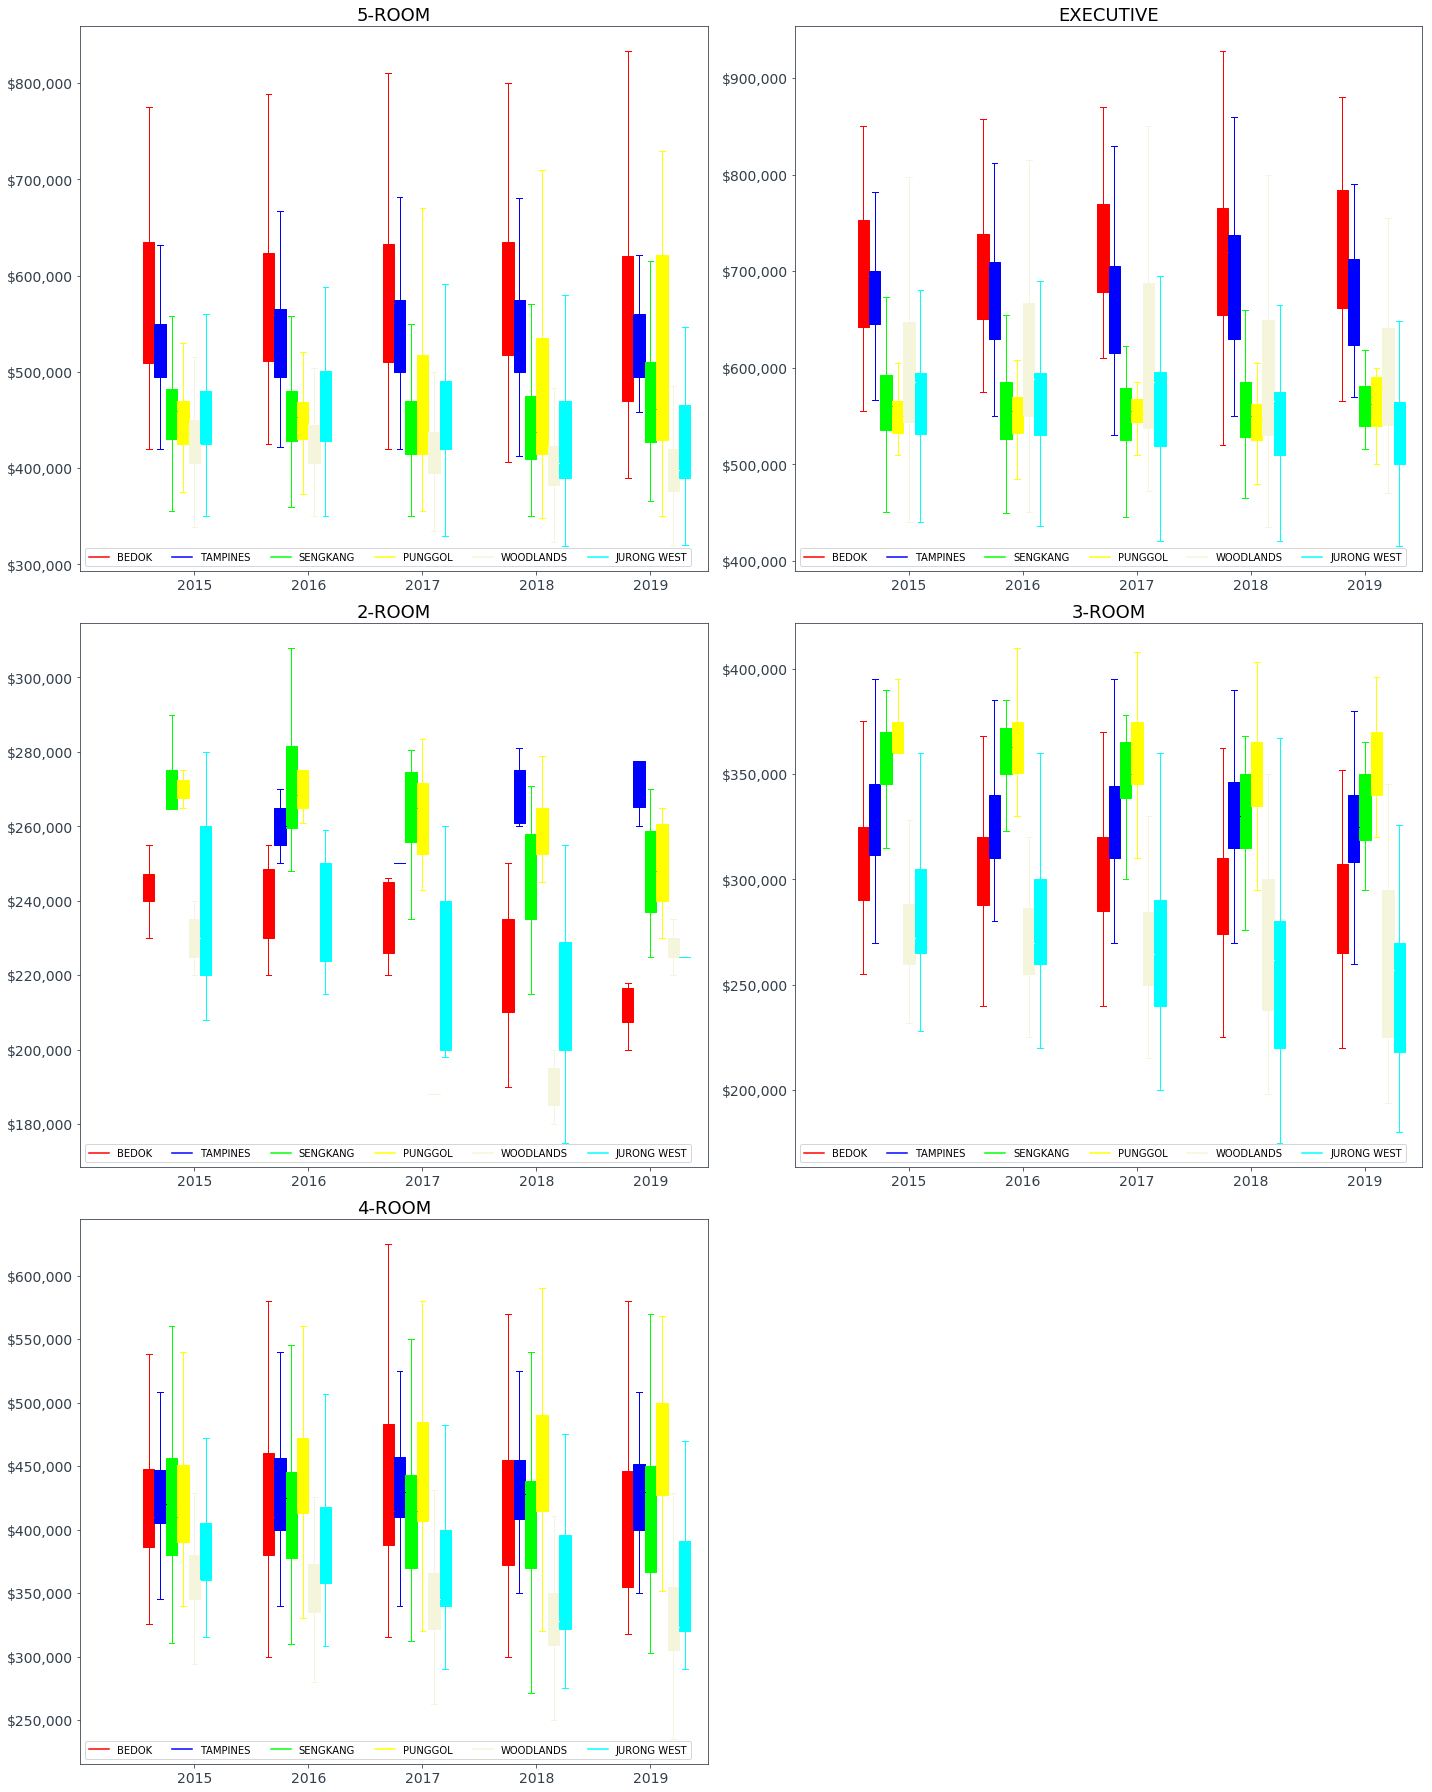

In [24]:
data_list = []

for flattype in ["5 ROOM", "EXECUTIVE", "2 ROOM", "3 ROOM", "4 ROOM"]:
    flattype_list = []
    for town in ["BEDOK", "TAMPINES", "SENGKANG", "PUNGGOL", "WOODLANDS", "JURONG WEST"]:
        flattype_list.append([list(RP_Town_flattype_Period[town][flattype]["vals"][i]) for i in range(7,12)])
    data_list.append(flattype_list)

data_list_labels = ["BEDOK", "TAMPINES","SENGKANG","PUNGGOL","WOODLANDS","JURONG WEST"]
title_labels = ["5-ROOM", "EXECUTIVE", "2-ROOM", "3-ROOM", "4-ROOM"]
ticks = ['2015', '2016', '2017', '2018', '2019']

def set_box_color(bp, color):
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=color)

    for patch in bp['boxes']:
        patch.set(facecolor=color)   

plt.figure(figsize=(20,25))
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    
for i, data in enumerate(data_list):
    ax1 = plt.subplot(321 + i)

    ax1.set_title(title_labels[i], fontsize=18)
    ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
    ax1.yaxis.set_tick_params(labelsize=14)

    bp1 = plt.boxplot(data[0], positions=np.array(range(len(data[0])))*2.1+0.2, sym='', widths=0.2, patch_artist=True)
    bp2 = plt.boxplot(data[1], positions=np.array(range(len(data[1])))*2.1+0.4, sym='', widths=0.2, patch_artist=True)
    bp3 = plt.boxplot(data[2], positions=np.array(range(len(data[2])))*2.1+0.6, sym='', widths=0.2, patch_artist=True)
    bp4 = plt.boxplot(data[3], positions=np.array(range(len(data[3])))*2.1+0.8, sym='', widths=0.2, patch_artist=True)
    bp5 = plt.boxplot(data[4], positions=np.array(range(len(data[4])))*2.1+1.0, sym='', widths=0.2, patch_artist=True)
    bp6 = plt.boxplot(data[5], positions=np.array(range(len(data[5])))*2.1+1.2, sym='', widths=0.2, patch_artist=True)
    set_box_color(bp1, 'red') # colors are from http://colorbrewer2.org/
    set_box_color(bp2, 'blue')
    set_box_color(bp3, 'lime')
    set_box_color(bp4, 'yellow')
    set_box_color(bp5, 'beige')
    set_box_color(bp6, 'cyan')

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='red', label=data_list_labels[0])
    plt.plot([], c='blue', label=data_list_labels[1])
    plt.plot([], c='lime', label=data_list_labels[2])
    plt.plot([], c='yellow', label=data_list_labels[3])
    plt.plot([], c='beige', label=data_list_labels[4])
    plt.plot([], c='cyan', label=data_list_labels[5])
    plt.legend(loc="lower left", ncol=len(data_list_labels))

    plt.xticks(range(1, len(ticks) * 2, 2), ticks, fontsize=14)
    plt.xlim(-1, len(ticks)*2)
    plt.tight_layout()

<a id='Section5.3'><h5>5.3. Rental Flat Price comparison for 4- and 5-room flats in top town estates by transaction volume</h5></a>

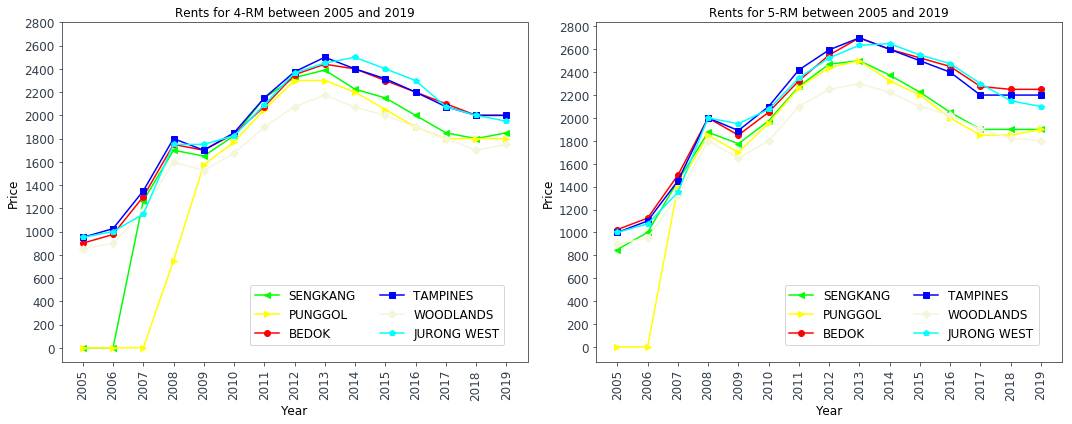

In [25]:
def LinePlot(ds, cat_list, subcat_list, time_period):
    """Function for displaying line chart.

    Args:
        ds (numpy array)    : Yearly median rental flat price per flat type
        cat_list (list)     : List of town estates
        subcat_list (list)  : List of flat types
        time_period (tuple) : Start and end year info e.g. (2008, 2019)
        
    Returns:
        None
    """
    
    cat_colors = {'BEDOK': 'red', 'TAMPINES': 'blue', 'SENGKANG': 'lime', 'PUNGGOL': 'yellow', 
                   'WOODLANDS': 'beige', 'JURONG WEST': 'cyan', 'YISHUN': 'lightgray'}
    cat_markers = {'BEDOK': 'o', 'TAMPINES': 's', 'SENGKANG': '<', 'PUNGGOL': '>', 
                   'WOODLANDS': 'D', 'JURONG WEST': 'p', 'YISHUN': 'x'}
    
    ax = plt.figure(figsize=(15,6))
    
    for idx, subcat in enumerate(subcat_list):
        ax = plt.subplot(121 + idx)

        for cat in cat_list:
            y = np.array(ds[cat][subcat]["median"])
            x = np.array(range(time_period[0], time_period[1] + 1))
            plt.plot(x,y, color=cat_colors[cat], marker=cat_markers[cat], markersize=6)

        plt.ylabel('Price', size=12)
        plt.xlabel('Year', size=12)
        plt.title("Rents for {} between {} and {}".format(subcat, time_period[0], time_period[1]), fontsize=12)
        plt.yticks(np.arange(0, 3000, 200), size=12)
        plt.xticks(np.arange(2005, 2020), rotation='vertical', size=12)
        plt.legend(cat_list, loc='lower right', bbox_to_anchor=(0.95,0.05), borderaxespad=0., ncol=2, fontsize=12)
    plt.tight_layout()
    plt.show()

time_period = (2005, 2019)
towns = ['SENGKANG', 'PUNGGOL', 'BEDOK', 'TAMPINES', 'WOODLANDS', 'JURONG WEST']
flattypes = ['4-RM', '5-RM']

LinePlot(MR_Town_flattype_Period, towns, flattypes, time_period)

<a id='Section5.4'><h5>5.4 Correlation of resale flat price and flat type completion status</h5></a>

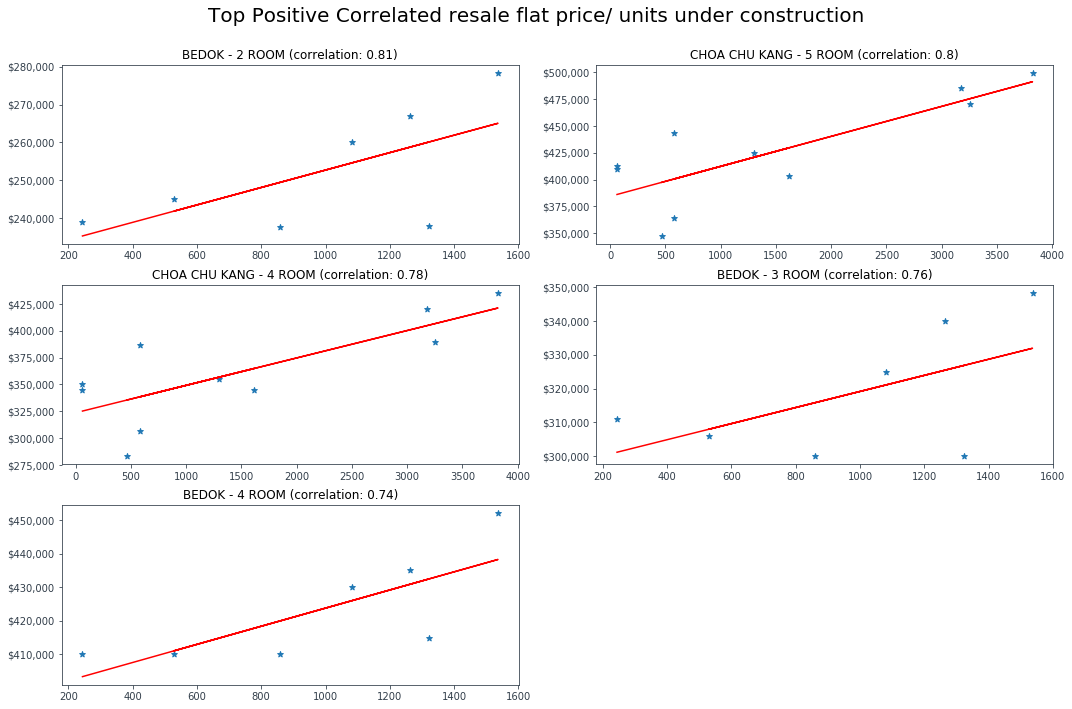

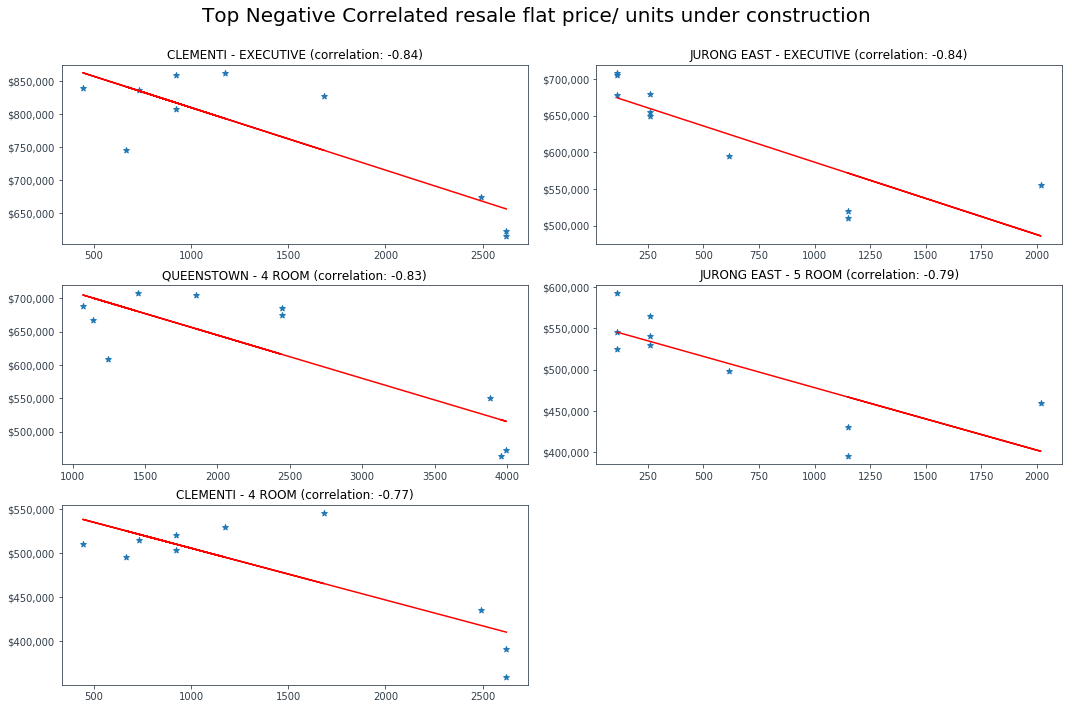

In [26]:
def plotScatter(corrList, rs_RFP, rs_UCS, status):
    """Function to display scatter plot of correlation info.

    Args:
        corrList (List)     : List of top 5 positive/negative correlated town Estate Flat Type/ number of units 
        rs_RFP (Dictionary) : Dictionary of yearly median resale flat price per town estate
        rs_UCS (Dictionary) : Dictionary of yearly median number of units completed/ under construction per town estate
        status (String)     : Unit completion status (COMPLETED/ UNDER CONS)
        
    Returns:
        None
    """
    
    for j, corr in enumerate(corrList):
        idx = 0

        plt.figure(figsize=(15,10))

        # set plot title based on completion status and top/bottom ranking
        if(status == "UNDER CONS"):
            if(j == 0):
                title = "Top Positive Correlated resale flat price/ units under construction"
            else:
                title = "Top Negative Correlated resale flat price/ units under construction"
        else:
            if(j == 0):
                title = "Top Positive Correlated resale flat price/ completed units"
            else:
                title = "Top Negative Correlated resale flat price/ completed units"

        plt.suptitle(title, fontsize=20)
        for key, value in corr[0:5]:
            ax = plt.subplot(321 + idx)

            # get town estate
            town = key.split("-")[0].strip()
            
            # get flat type
            cat_type = key.split("-")[1].strip()

            # get median resale flat prices per year for specific completion status
            x = rs_UCS[town][status]["median"]
             
            # remove zero median flat prices from result for correlation analysis    
            x_idx = [i for i, e in enumerate(x) if e != 0]
            x_nonzero = [x[i] for i in x_idx]

            # get median resale flat prices per year for specific town estate/ flat type
            y = rs_RFP[town][cat_type]["median"]
            y_nonzero = [y[i] for i in x_idx]

            # get linear regression trend line gradient/bias information 
            m, b = np.polyfit(x_nonzero, y_nonzero, deg=1)

            # create scatter plot for correlation between unit completion status and 
            # median flat prices per town estate/ flat type
            plt.scatter(x_nonzero,y_nonzero, marker="*")
            
            # create linear regression trend line
            plt.plot(x_nonzero, [m * x + b for x in x_nonzero], color='red')
            
            # set formatting for 
            ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))

            plt.title("{} - {} (correlation: {})".format(town, cat_type, value))

            idx += 1
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()

corr_uc = [top_poscorr_uc, top_negcorr_uc]
plotScatter(corr_uc, RP_Town_flattype_Period, RP_Town_Units_Period, "UNDER CONS")